<a href="https://colab.research.google.com/github/GiseC/TelecomX2/blob/main/TP2_TelecomX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modelado Predictivo para la Evasión de Clientes en Telecom X

El presente proyecto tiene como objetivo desarrollar un pipeline robusto de modelado predictivo orientado a identificar con anticipación los clientes con mayor probabilidad de cancelar sus servicios en Telecom X, empresa que enfrenta una tasa de evasión del 26,5%.

El notebook incluye preparación de datos, análisis exploratorio dirigido, selección/creación de variables, entrenamiento de **múltiples modelos**, evaluación con **métricas de clasificación**, e **interpretabilidad** (importancia de variables y coeficientes).

> **Archivos base**: se parte del dataset limpio subido trabajado en la primera parte del Challenge de Alura LATAM.

**Si el nombre de la columna objetivo difiere de `Evasion_bin`/`Churn`, el notebook intentará detectarla automáticamente.**

El resultado final no solo es un clasificador predictivo, sino también un insumo analítico para comprender los factores subyacentes que impulsan la cancelación de servicios, sentando las bases para una estrategia de retención basada en datos.

## Preprocesamiento de datos
Limpieza, transformación y codificación de variables categóricas y numéricas, asegurando la calidad y homogeneidad de los datos para el modelado.


In [445]:
#Importacion de Librerias
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_curve, roc_auc_score)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample


In [446]:
# Exploración inicial de datos

# Cargamos dataset
df = pd.read_csv("df_limpo.csv")
df.head()

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,Total.Day,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,2.20,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,2.01,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,2.34,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,3.17,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,2.97,83.9,267.40


##Diccionario de datos

*   customerID: número de identificación único de cada cliente
*   Churn: si el cliente dejó o no la empresa
*   gender: género (masculino y femenino)
*   SeniorCitizen: información sobre si un cliente tiene o no una edad igual o mayor a 65 años
*   Partner: si el cliente tiene o no una pareja
*   Dependents: si el cliente tiene o no dependientes
*   tenure: meses de contrato del cliente
*   PhoneService: suscripción al servicio telefónico
*   MultipleLines: suscripción a más de una línea telefónica
*   InternetService: suscripción a un proveedor de internet
*   OnlineSecurity: suscripción adicional de seguridad en línea
*   OnlineBackup: suscripción adicional de respaldo en línea
*   DeviceProtection: suscripción adicional de protección del dispositivo
*   TechSupport: suscripción adicional de soporte técnico, menor tiempo de espera
*   StreamingTV: suscripción de televisión por cable
*   StreamingMovies: suscripción de streaming de películas
*   Contract: tipo de contrato
*   PaperlessBilling: si el cliente prefiere recibir la factura en línea
*   PaymentMethod: forma de pago
*   Charges.Monthly: total de todos los servicios del cliente por mes
*   Charges.Total: total gastado por el cliente

##Análisis exploratorio y selección de variables
Evaluación de correlaciones (Pearson), análisis bivariado a fin de identificar los predictores más relevantes del churn.

In [447]:
#Estructura general
print("📌 Dimensiones del dataset:", df.shape)
print("\n📌 Tipos de datos:\n")
print(df.dtypes)

📌 Dimensiones del dataset: (7043, 22)

📌 Tipos de datos:

customerID                    object
Churn                         object
customer.gender               object
customer.SeniorCitizen         int64
customer.Partner              object
customer.Dependents           object
customer.tenure                int64
phone.PhoneService            object
phone.MultipleLines           object
internet.InternetService      object
internet.OnlineSecurity       object
internet.OnlineBackup         object
internet.DeviceProtection     object
internet.TechSupport          object
internet.StreamingTV          object
internet.StreamingMovies      object
account.Contract              object
account.PaperlessBilling      object
account.PaymentMethod         object
Total.Day                    float64
account.Charges.Monthly      float64
account.Charges.Total        float64
dtype: object


In [448]:
#Valores faltantes
print("\n📌 Valores nulos por columna:\n")
print(df.isnull().sum())


📌 Valores nulos por columna:

customerID                    0
Churn                         0
customer.gender               0
customer.SeniorCitizen        0
customer.Partner              0
customer.Dependents           0
customer.tenure               0
phone.PhoneService            0
phone.MultipleLines           0
internet.InternetService      0
internet.OnlineSecurity       0
internet.OnlineBackup         0
internet.DeviceProtection     0
internet.TechSupport          0
internet.StreamingTV          0
internet.StreamingMovies      0
account.Contract              0
account.PaperlessBilling      0
account.PaymentMethod         0
Total.Day                    11
account.Charges.Monthly       0
account.Charges.Total        11
dtype: int64


In [449]:
# Distribución de la variable objetivo (Churn)
print("\n📌 Distribución de la variable objetivo (Churn):\n")
print(df["Churn"].value_counts())
print("\nProporción:\n")
print(df["Churn"].value_counts(normalize=True))


📌 Distribución de la variable objetivo (Churn):

Churn
No     5174
Yes    1869
Name: count, dtype: int64

Proporción:

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [450]:
#Creamos columna Churn_bin de tipo binario
#df['Churn_bin'] = df['Churn'].map({'No': 0, 'Yes': 1}).astype(int)

# Mostrar las primeras filas para verificar la nueva columna y su tipo de dato
display(df.head())
display(df.dtypes)

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,Total.Day,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,2.20,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,2.01,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,2.34,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,3.17,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,2.97,83.9,267.40


,0
customerID,object
Churn,object
customer.gender,object
customer.SeniorCitizen,int64
customer.Partner,object
customer.Dependents,object
customer.tenure,int64
phone.PhoneService,object
phone.MultipleLines,object
internet.InternetService,object


In [451]:
#Estadísticas descriptivas de variables numéricas
print("\n📌 Estadísticas descriptivas (numéricas):\n")
print(df.describe())


📌 Estadísticas descriptivas (numéricas):

       customer.SeniorCitizen  customer.tenure    Total.Day  \
count             7043.000000      7043.000000  7032.000000   
mean                 0.162147        32.371149     2.159879   
std                  0.368612        24.559481     1.006217   
min                  0.000000         0.000000     0.460000   
25%                  0.000000         9.000000     1.207500   
50%                  0.000000        29.000000     2.350000   
75%                  0.000000        55.000000     3.010000   
max                  1.000000        72.000000     4.050000   

       account.Charges.Monthly  account.Charges.Total  
count              7043.000000            7032.000000  
mean                 64.761692            2283.300441  
std                  30.090047            2266.771362  
min                  18.250000              18.800000  
25%                  35.500000             401.450000  
50%                  70.350000            1397.475000

In [452]:
# Resumen de variables categóricas
print("\n📌 Resumen de variables categóricas:\n")
categorical_cols = df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    print(f"\n{col}:\n", df[col].value_counts().head(10))  # top 10 categorías


📌 Resumen de variables categóricas:


customerID:
 customerID
9995-HOTOH    1
0002-ORFBO    1
0003-MKNFE    1
9970-QBCDA    1
9968-FFVVH    1
9967-ATRFS    1
9965-YOKZB    1
9964-WBQDJ    1
9962-BFPDU    1
9961-JBNMK    1
Name: count, dtype: int64

Churn:
 Churn
No     5174
Yes    1869
Name: count, dtype: int64

customer.gender:
 customer.gender
Male      3555
Female    3488
Name: count, dtype: int64

customer.Partner:
 customer.Partner
No     3641
Yes    3402
Name: count, dtype: int64

customer.Dependents:
 customer.Dependents
No     4933
Yes    2110
Name: count, dtype: int64

phone.PhoneService:
 phone.PhoneService
Yes    6361
No      682
Name: count, dtype: int64

phone.MultipleLines:
 phone.MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

internet.InternetService:
 internet.InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

internet.OnlineSecurity:
 internet.Onlin

In [453]:
# Filtrar filas donde 'account.Charges.Total' es nulo
filas_con_nulos = df[df['account.Charges.Total'].isnull()]

# Mostrar las filas filtradas
display(filas_con_nulos)

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,Total.Day,account.Charges.Monthly,account.Charges.Total
945,1371-DWPAZ,No,Female,0,Yes,Yes,0,No,No phone service,DSL,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),NaN,56.05,NaN
1731,2520-SGTTA,No,Female,0,Yes,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,NaN,20.00,NaN
1906,2775-SEFEE,No,Male,0,No,Yes,0,Yes,Yes,DSL,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),NaN,61.90,NaN
2025,2923-ARZLG,No,Male,0,Yes,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,NaN,19.70,NaN
2176,3115-CZMZD,No,Male,0,No,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,NaN,20.25,NaN
2250,3213-VVOLG,No,Male,0,Yes,Yes,0,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,NaN,25.35,NaN
2855,4075-WKNIU,No,Female,0,Yes,Yes,0,Yes,Yes,DSL,...,Yes,Yes,Yes,No,Two year,No,Mailed check,NaN,73.35,NaN
3052,4367-NUYAO,No,Male,0,Yes,Yes,0,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,NaN,25.75,NaN
3118,4472-LVYGI,No,Female,0,Yes,Yes,0,No,No phone service,DSL,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),NaN,52.55,NaN
4054,5709-LVOEQ,No,Female,0,Yes,Yes,0,Yes,No,DSL,...,Yes,No,Yes,Yes,Two year,No,Mailed check,NaN,80.85,NaN


##Tratamiento de los datos


Se observan datos en Charges.Total con nulos, se eliminan para limpiar datos.

Eliminación de columnas que no aportan valor al análisis o a los modelos predictivos. Estas columnas no ayudan en la predicción de la cancelación.

In [454]:
# Reemplazar valores nulos en 'account.Charges.Total' por 0.0
df["account.Charges.Total"] = df["account.Charges.Total"].fillna(0.0)

# Verificar si aún quedan nulos en la columna
print("Valores nulos en account.Charges.Total:", df["account.Charges.Total"].isnull().sum())

# Mostrar algunos registros para confirmar
print(df[["customerID", "account.Charges.Total"]].head(10))


Valores nulos en account.Charges.Total: 0
   customerID  account.Charges.Total
0  0002-ORFBO                 593.30
1  0003-MKNFE                 542.40
2  0004-TLHLJ                 280.85
3  0011-IGKFF                1237.85
4  0013-EXCHZ                 267.40
5  0013-MHZWF                 571.45
6  0013-SMEOE                7904.25
7  0014-BMAQU                5377.80
8  0015-UOCOJ                 340.35
9  0016-QLJIS                5957.90


Se eliminan columnas innecesaria en la etapa de limpieza de datos

In [455]:
#Teniendo en cuenta los datos analizados en la primera etapa de Telecom
df = df.drop(columns={"customerID","customer.gender","Total.Day"})
df.head()

,Churn,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,No,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,No,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,Yes,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,Yes,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,Yes,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


In [456]:
#Separando las variables categoricas
columnas_categoricas = df.select_dtypes(include="object").columns
print(columnas_categoricas)

Index(['Churn', 'customer.Partner', 'customer.Dependents',
       'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService',
       'internet.OnlineSecurity', 'internet.OnlineBackup',
       'internet.DeviceProtection', 'internet.TechSupport',
       'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract',
       'account.PaperlessBilling', 'account.PaymentMethod'],
      dtype='object')


In [457]:
df_clean = df.copy()

In [458]:
cols_to_fix = ['internet.OnlineSecurity', 'internet.OnlineBackup',
       'internet.DeviceProtection', 'internet.TechSupport',
       'internet.StreamingTV', 'internet.StreamingMovies']

for col in cols_to_fix:
    df_clean[col] = df_clean[col].replace('No internet service','No')

##Transformando las variables categóricas a formato numérico para hacerlas compatibles con los algoritmos de machine learning

In [459]:
df_encoded = pd.get_dummies(df_clean, columns = columnas_categoricas, drop_first=True)
df_encoded

,customer.SeniorCitizen,customer.tenure,account.Charges.Monthly,account.Charges.Total,Churn_Yes,customer.Partner_Yes,customer.Dependents_Yes,phone.PhoneService_Yes,phone.MultipleLines_No phone service,phone.MultipleLines_Yes,...,internet.DeviceProtection_Yes,internet.TechSupport_Yes,internet.StreamingTV_Yes,internet.StreamingMovies_Yes,account.Contract_One year,account.Contract_Two year,account.PaperlessBilling_Yes,account.PaymentMethod_Credit card (automatic),account.PaymentMethod_Electronic check,account.PaymentMethod_Mailed check
0,0,9,65.60,593.30,False,True,True,True,False,False,...,False,True,True,False,True,False,True,False,False,True
1,0,9,59.90,542.40,False,False,False,True,False,True,...,False,False,False,True,False,False,False,False,False,True
2,0,4,73.90,280.85,True,False,False,True,False,False,...,True,False,False,False,False,False,True,False,True,False
3,1,13,98.00,1237.85,True,True,False,True,False,False,...,True,False,True,True,False,False,True,False,True,False
4,1,3,83.90,267.40,True,True,False,True,False,False,...,False,True,True,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,13,55.15,742.90,False,False,False,True,False,False,...,False,True,False,False,True,False,False,False,False,True
7039,0,22,85.10,1873.70,True,True,False,True,False,True,...,False,False,False,True,False,False,True,False,True,False
7040,0,2,50.30,92.75,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,True
7041,0,67,67.85,4627.65,False,True,True,True,False,False,...,True,True,False,True,False,True,False,False,False,True


In [460]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   customer.SeniorCitizen                         7043 non-null   int64  
 1   customer.tenure                                7043 non-null   int64  
 2   account.Charges.Monthly                        7043 non-null   float64
 3   account.Charges.Total                          7043 non-null   float64
 4   Churn_Yes                                      7043 non-null   bool   
 5   customer.Partner_Yes                           7043 non-null   bool   
 6   customer.Dependents_Yes                        7043 non-null   bool   
 7   phone.PhoneService_Yes                         7043 non-null   bool   
 8   phone.MultipleLines_No phone service           7043 non-null   bool   
 9   phone.MultipleLines_Yes                        7043 

In [461]:
df_encoded.isnull().sum()

,0
customer.SeniorCitizen,0
customer.tenure,0
account.Charges.Monthly,0
account.Charges.Total,0
Churn_Yes,0
customer.Partner_Yes,0
customer.Dependents_Yes,0
phone.PhoneService_Yes,0
phone.MultipleLines_No phone service,0
phone.MultipleLines_Yes,0


##Correlación de variables

In [462]:
corr = df_encoded.corr()

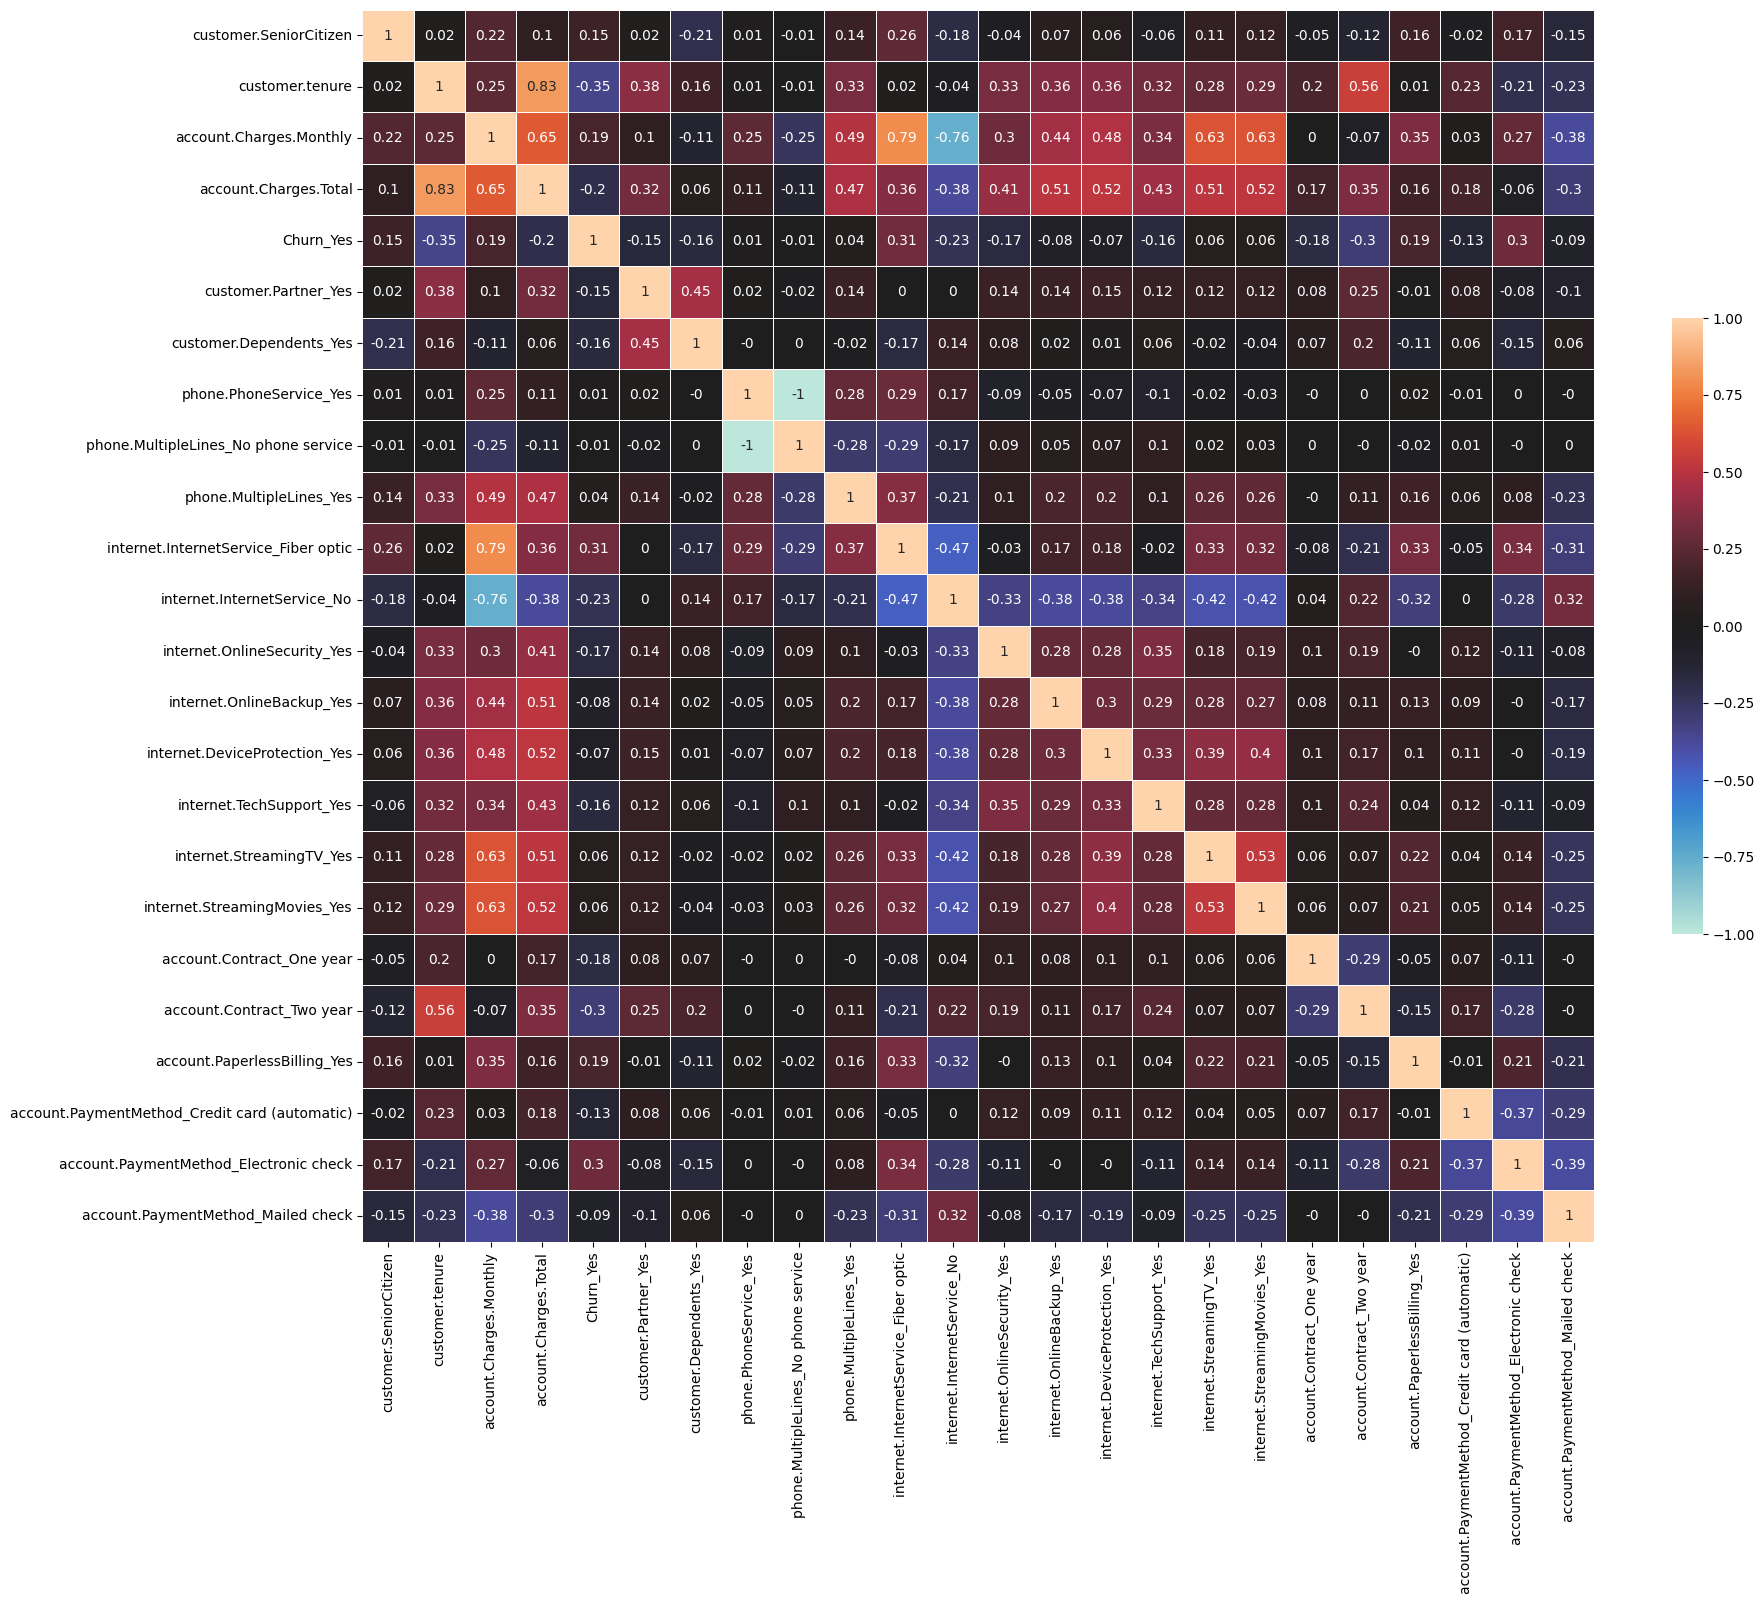

In [463]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(20, 16))
ax = sns.heatmap(np.round(corr, 2), vmax =1, vmin = -1, center = 0, square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})
plt.show()


Al ser tantos valores, seleccionamos las variables que esten correlacionadas con la variable target, Churn_Yes, que superen un limite. Aplicamos una mascara

['customer.tenure', 'Churn_Yes', 'internet.InternetService_Fiber optic', 'internet.InternetService_No', 'account.Contract_Two year', 'account.PaymentMethod_Electronic check']


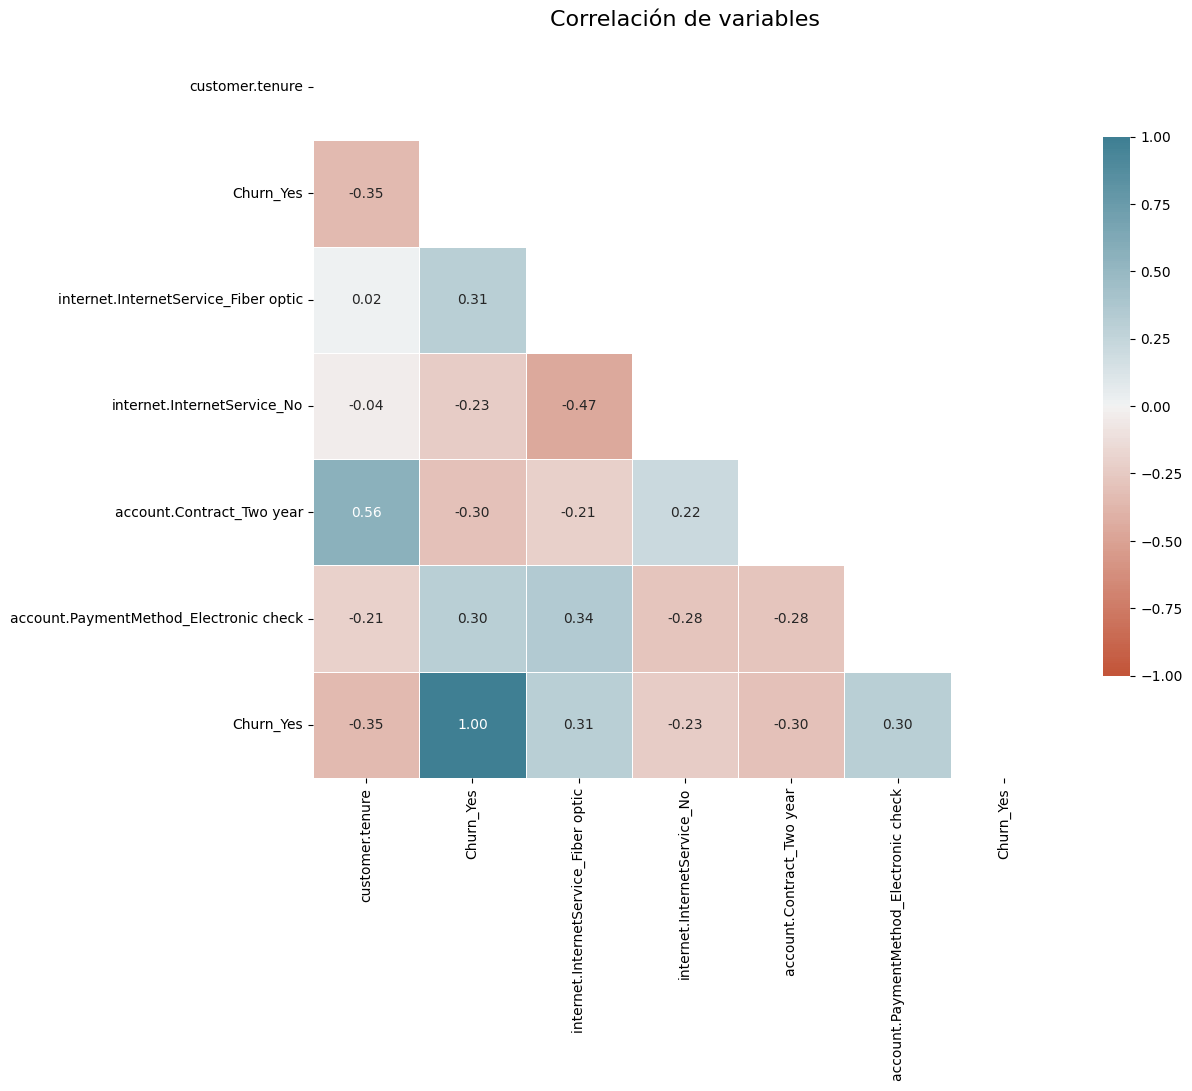

In [464]:
#Definimos la variable target
target_var = "Churn_Yes"

limite = 0.2

#filtramos las variables que tiene una correlacon absoluta mayor o igual al limite
var_relevantes = corr.index[abs(corr[target_var]) >= limite].to_list()
print(var_relevantes)

#corroborar que la variable target este en la lista
if target_var in var_relevantes:
  var_relevantes.append(target_var)

#creamos la matriz de correlacion con las variables seleccionadas
corr_relevantes = corr.loc[var_relevantes, var_relevantes]

#generamos una mascara para esconder el triangulo superior de la matriz, incluyendo la diagonal
mascara = np.triu(np.ones_like(corr_relevantes, dtype=bool))

#hacemos la grafica
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_relevantes,
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink":0.7},
    mask = mascara
)
plt.title("Correlación de variables", fontsize=16)
plt.show()


#Analisis Dirigido

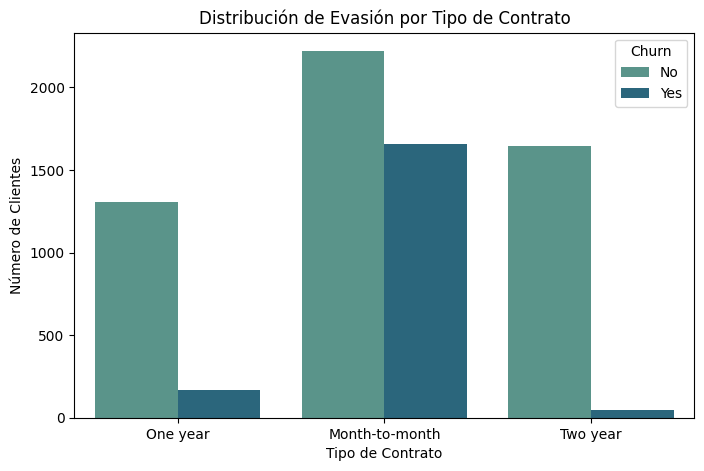

In [465]:
# Analisis de tipo de contrato y 'Churn'
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='account.Contract', hue='Churn', palette='crest')
plt.title('Distribución de Evasión por Tipo de Contrato')
plt.xlabel('Tipo de Contrato')
plt.ylabel('Número de Clientes')
plt.show()

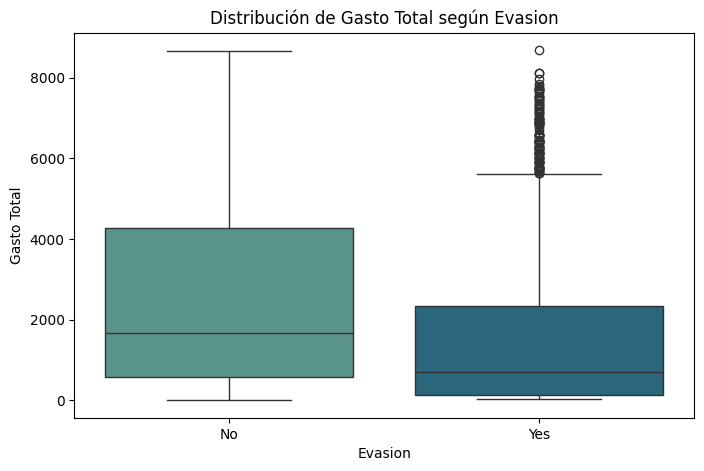

In [466]:
# Analisis de Gasto Total y 'Churn'
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Churn', y='account.Charges.Total', palette='crest')
plt.title('Distribución de Gasto Total según Evasion')
plt.xlabel('Evasion')
plt.ylabel('Gasto Total')
plt.show()

In [467]:
df_encoded["Churn_Yes"].value_counts(normalize=True)

,proportion
Churn_Yes,
False,0.73463
True,0.26537


ESta afectado, sesgado, se debe hacer balanceamiento

#Analisis de Multicolinealidad

In [468]:
df_encoded.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   customer.SeniorCitizen                         7043 non-null   int64  
 1   customer.tenure                                7043 non-null   int64  
 2   account.Charges.Monthly                        7043 non-null   float64
 3   account.Charges.Total                          7043 non-null   float64
 4   Churn_Yes                                      7043 non-null   bool   
 5   customer.Partner_Yes                           7043 non-null   bool   
 6   customer.Dependents_Yes                        7043 non-null   bool   
 7   phone.PhoneService_Yes                         7043 non-null   bool   
 8   phone.MultipleLines_No phone service           7043 non-null   bool   
 9   phone.MultipleLines_Yes                        7043 

In [469]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [470]:
from sklearn.preprocessing import StandardScaler

df_dif = df_encoded.copy()

columnas_numericas = ["customer.tenure", "account.Charges.Monthly", "account.Charges.Total", "customer.SeniorCitizen"]

#Imicializamos la escala
scala = StandardScaler()

#aplicamos la escala a las columnas numericas
df_dif[columnas_numericas] = scala.fit_transform(df_dif[columnas_numericas])

display(df_dif.head())

,customer.SeniorCitizen,customer.tenure,account.Charges.Monthly,account.Charges.Total,Churn_Yes,customer.Partner_Yes,customer.Dependents_Yes,phone.PhoneService_Yes,phone.MultipleLines_No phone service,phone.MultipleLines_Yes,...,internet.DeviceProtection_Yes,internet.TechSupport_Yes,internet.StreamingTV_Yes,internet.StreamingMovies_Yes,account.Contract_One year,account.Contract_Two year,account.PaperlessBilling_Yes,account.PaymentMethod_Credit card (automatic),account.PaymentMethod_Electronic check,account.PaymentMethod_Mailed check
0,-0.439916,-0.951682,0.027862,-0.744026,False,True,True,True,False,False,...,False,True,True,False,True,False,True,False,False,True
1,-0.439916,-0.951682,-0.161583,-0.766482,False,False,False,True,False,True,...,False,False,False,True,False,False,False,False,False,True
2,-0.439916,-1.155283,0.303720,-0.881874,True,False,False,True,False,False,...,True,False,False,False,False,False,True,False,True,False
3,2.273159,-0.788800,1.104706,-0.459662,True,True,False,True,False,False,...,True,False,True,True,False,False,True,False,True,False
4,2.273159,-1.196004,0.636080,-0.887808,True,True,False,True,False,False,...,False,True,True,False,False,False,True,False,False,True


In [471]:
X = df_encoded.drop(columns=["Churn_Yes"])
X_const = add_constant(X)

In [472]:
X_const = X_const.astype(float)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

display(vif_data.sort_values(by="VIF", ascending=False))

,Variable,VIF
7,phone.PhoneService_Yes,inf
8,phone.MultipleLines_No phone service,inf
3,account.Charges.Monthly,864.964482
10,internet.InternetService_Fiber optic,148.241117
11,internet.InternetService_No,104.210020
17,internet.StreamingMovies_Yes,24.106279
16,internet.StreamingTV_Yes,24.053437
4,account.Charges.Total,10.791279
2,customer.tenure,7.527252
9,phone.MultipleLines_Yes,7.272747


phone.PhoneSErvice_Yes y phone.MultipleLines_No phone service tienden a infinito

In [473]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Creo una copia
X_filtrada = X_const.copy()

# REmuevo las variables que tienden a infinito
cols_to_drop = [
    "phone.PhoneService_Yes",
    "phone.MultipleLines_No phone service"
]
X_filtrada.drop(columns=cols_to_drop, inplace=True)

#Borro datos redundantes
X_filtrada.drop(columns=["internet.InternetService_No"], inplace=True)

# Vuelvo a realizar VIF
X_filtrada = X_filtrada.astype(float)

vif_data = pd.DataFrame()
vif_data["feature"] = X_filtrada.columns
vif_data["VIF"] = [variance_inflation_factor(X_filtrada.values, i) for i in range(X_filtrada.shape[1])]

display(vif_data.sort_values(by="VIF", ascending=False))

,feature,VIF
0,const,35.523487
3,account.Charges.Monthly,18.157790
4,account.Charges.Total,10.685707
2,customer.tenure,7.492443
8,internet.InternetService_Fiber optic,6.996284
16,account.Contract_Two year,2.512831
14,internet.StreamingMovies_Yes,2.188764
13,internet.StreamingTV_Yes,2.187277
19,account.PaymentMethod_Electronic check,1.967086
20,account.PaymentMethod_Mailed check,1.850380


se elimina la columna Charges.Total porque es una combinacion de tenure y cobro mensual

In [474]:
X_filtrada.drop(columns=["account.Charges.Total"], inplace=True)

In [475]:
vif_data_final = pd.DataFrame()
vif_data_final["feature"] = X_filtrada.columns
vif_data_final["VIF"] = [variance_inflation_factor(X_filtrada.values, i) for i in range(X_filtrada.shape[1])]

# === Mostrar los resultados ordenados ===
display(vif_data_final.sort_values(by="VIF", ascending=False))

,feature,VIF
0,const,28.730532
3,account.Charges.Monthly,17.282320
7,internet.InternetService_Fiber optic,6.933121
2,customer.tenure,2.782187
15,account.Contract_Two year,2.502475
12,internet.StreamingTV_Yes,2.165476
13,internet.StreamingMovies_Yes,2.164424
18,account.PaymentMethod_Electronic check,1.963865
19,account.PaymentMethod_Mailed check,1.827867
11,internet.TechSupport_Yes,1.711953


#Modelos predictivos



In [476]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

X = df_encoded.drop(columns=['Churn_Yes'])
y = df_encoded['Churn_Yes']

In [477]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [478]:
#Normalizamos los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [479]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

In [480]:
#Regresión logistica
# Instanciar y entrenar
lr = LogisticRegression(random_state=42)
lr.fit(X_train_bal, y_train_bal)

# Predicciones
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

# Evaluación
print("Regresión Logística")
print("Exactitud:", accuracy_score(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr))
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Regresión Logística
Exactitud: 0.7458589682915286
ROC AUC: 0.840233750482386
Matriz de Confusión:
 [[1131  421]
 [ 116  445]]
              precision    recall  f1-score   support

       False       0.91      0.73      0.81      1552
        True       0.51      0.79      0.62       561

    accuracy                           0.75      2113
   macro avg       0.71      0.76      0.72      2113
weighted avg       0.80      0.75      0.76      2113



El modelo logra captar a la mayoría de los clientes que se van (recall alto en True), aunque comete muchos falsos positivos (clientes que no se irían pero predice que sí)

In [481]:
#Random Forest
# Instanciar y entrenar
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_bal, y_train_bal)

# Predicciones
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

# Evaluación
print("Random Forest")
print("Exactitud:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest
Exactitud: 0.7770941788925698
ROC AUC: 0.8232359602697686
Matriz de Confusión:
 [[1304  248]
 [ 223  338]]
              precision    recall  f1-score   support

       False       0.85      0.84      0.85      1552
        True       0.58      0.60      0.59       561

    accuracy                           0.78      2113
   macro avg       0.72      0.72      0.72      2113
weighted avg       0.78      0.78      0.78      2113



Este modelo clasifica mejor a los clientes que permanecen (False), pero pierde más casos reales de churn (recall más bajo en True)

#Comparación de modelos utilizados

**Random Forest** obtiene mayor exactitud general (0.78 vs 0.75) y un balance más estable entre precisión y recall.

**Regresión Logística** destaca en el recall de la clase churn (0.79 vs 0.60), lo cual puede ser más valioso en escenarios de negocio donde detectar clientes en riesgo es prioritario, aunque a costa de generar muchos falsos positivos.

*  Overfitting vs Underfitting

Regresión Logística: al ser un modelo lineal, no muestra señales fuertes de overfitting. Su desempeño es consistente, pero podría estar subajustando (underfitting) algunos patrones complejos de los datos, especialmente en la clase True (churn).

Random Forest: muestra una mejor capacidad de ajuste en general (mejor exactitud), pero su menor recall en la clase churn puede sugerir que no está lo suficientemente calibrado para esa clase minoritaria. No hay evidencia clara de overfitting en los resultados actuales, pero sí podría beneficiarse de un ajuste de hiperparámetros para mejorar la sensibilidad en churn.

*  Interpretación práctica

El objetivo de negocio es minimizar la pérdida de clientes (churn), por ello Regresión Logística es preferible, ya que captura más casos reales aunque con falsos positivos que después pueden gestionarse con campañas de fidelización.

*  **Conclusión:**

Random Forest se lleva el mejor desempeño general, con mayor exactitud y equilibrio, pero necesita ajustes para mejorar recall en churn. Regresión Logística es más útil si la prioridad estratégica es detectar la mayor cantidad de clientes que se van, incluso aceptando más falsos positivos.

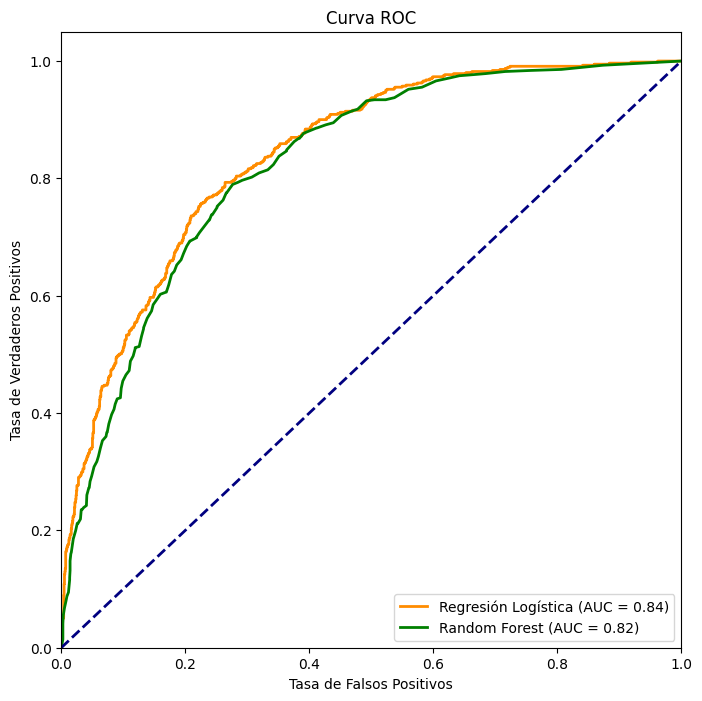

In [482]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular la curva ROC para cada modelo
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Graficar las curvas ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='Regresión Logística (AUC = %0.2f)' % roc_auc_lr)
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

#Analisis de la importancia de las variables en los modelos elegidos
En la Regresión Logística, variables como Meses de Contrato o Cobro Total suelen tener coeficientes significativos. Por ejemplo, un contrato más largo puede disminuir la probabilidad de cancelación. Por otro lado, variables como Métodos de pago electrónicos o cargos adicionales, sugiere que ciertas formas de pago o gastos adicionales están correlacionados con una mayor tasa de cancelación.
En Random Forest, se basa en la importancia de las variables calculada a partir de la reducción de la impureza en las divisiones de los árboles. Se mide cuánto contribuye cada variable a mejorar la clasificación a lo largo del bosque de árboles.
Si una variable aparece frecuentemente en los nodos superiores y genera divisiones que reducen mucho la impureza, tendrá una alta importancia.
Por ejemplo, Meses de Contrato, Tipo de Servicio o Cobro Mensual tienen los valores más altos de importancia, dado que explican gran parte de la diferencia entre clientes que permanecen y los que cancelan.

La Regresión Logística aporta explicabilidad clara: sabemos exactamente qué variables aumentan o reducen el riesgo de cancelación, y con qué magnitud. Esto es fundamental para el negocio porque permite diseñar estrategias dirigidas (ejemplo: reforzar beneficios para clientes con ciertos métodos de pago de riesgo).

El Random Forest, en cambio, aporta mayor capacidad predictiva y puede captar interacciones y no linealidades, aunque a costa de ser menos interpretable. Nos dice qué variables son las más relevantes, pero no de qué manera impactan en la cancelación.

**Conclusión:**

Para explicar el fenómeno y diseñar acciones de negocio, la Regresión Logística es más útil, ya que ofrece insights claros y accionables. Para maximizar la predicción de cancelaciones, el Random Forest es superior, porque maneja mejor la complejidad de los datos y las relaciones no lineales.
Idealmente, ambos modelos se complementan: la regresión logística aporta interpretación y el Random Forest potencia la capacidad de predicción.

#Conclusión Final
El análisis realizado mediante Regresión Logística y Random Forest permitió identificar con claridad los factores que más influyen en la cancelación de clientes y evaluar la capacidad predictiva de ambos enfoques. Ambos modelos alcanzaron resultados aceptables, aunque con diferencias relevantes:

Random Forest obtuvo una mayor exactitud (0.78 vs 0.75) y un mejor balance entre clases, mostrando capacidad de modelar relaciones no lineales y complejas.

Regresión Logística, si bien alcanzó un ROC AUC superior (0.84 vs 0.82), evidenció cierta limitación en la precisión sobre la clase minoritaria (clientes que cancelan), lo que sugiere mayor riesgo de falsos negativos.

En el análisis de variables, se observó:

*  La duración del contrato (Meses de Contrato) y el monto de facturación mensual (Cobro Total) fueron determinantes en la probabilidad de cancelación. Contratos de corto plazo y montos altos se asociaron con mayor riesgo de Evasión.

*  Variables relacionadas con servicios adicionales y características de la línea también tuvieron peso significativo, en especial en el modelo de Random Forest, que destacó la influencia de servicios específicos sobre la retención.

*  El modelo de Regresión Logística permitió observar direcciones claras: algunos servicios se correlacionaron positivamente con la cancelación, mientras que otros actuaron como factores protectores.

**Factores principales que afectan la cancelación**

Clientes con contratos cortos tienden a cancelar con mayor frecuencia.

Altos costos acumulados generan mayor probabilidad de abandono, especialmente en clientes recientes.

Menor adopción de servicios adicionales se asocia con mayor propensión a la cancelación.

**Estrategias de retención propuestas**

*  Fidelización con contratos de mayor duración: incentivar a clientes de corto plazo a migrar a planes de contrato más largos mediante descuentos o beneficios exclusivos.

*  Gestión de precios y beneficios: ofrecer planes personalizados o promociones a clientes con altos costos acumulados para reducir la percepción de carga económica.

*  Servicios de valor agregado: estimular la adopción de servicios adicionales que fortalezcan la permanencia del cliente, generando un mayor “costo de salida” en términos de beneficios perdidos.

*  Alertas tempranas y segmentación predictiva: aplicar los modelos desarrollados para detectar clientes con alto riesgo de churn y aplicar campañas específicas de retención.

En conclusión, la combinación de modelos predictivos y el análisis de variables relevantes brinda a la empresa una herramienta sólida para anticipar la cancelación de clientes y diseñar estrategias preventivas. El uso conjunto de Regresión Logística (por su capacidad interpretativa) y Random Forest (por su mayor desempeño general) ofrece un marco robusto tanto para la comprensión de los factores de Evasión como para la acción estratégica de retención.